<a href="https://colab.research.google.com/github/luoterolb/MIT-mod6/blob/main/Copia_de_Caso_de_estudio_6_1_Otero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Caso de estudio 6.1 - Trayectos en taxi en Nueva York

#### Nota: Si en algún momento cierra este notebook tendrá que volver a ejecutar todas las celdas de nuevo al abrirlo.

#### Nota: Puede que obtenga diferentes resultados numéricos al ejecutar el notebook en diferentes ocasiones. Esto es normal, simplemente entregue los resultados obtenidos.

# PYTHON PRINCIPIANTE

Como esta es la versión para principiantes, se ha incluído la mayor parte del código para ayudarle con el caso.

**Primero, rellene su información de contacto en la celda siguiente. A continuación, únicamente tendrá que escribir las respuestas a las preguntas que se plantean. Para el resto de celdas, simplemente ejecútelas seleccionando el botón de Run, en la parte superior del notebook** 


# Información de contacto

Lucía Otero Larre Borges

luoterolb@gmail.com

+598 99 599 517



# Configuración

Ejecute (Run) estas celdas para instalar los paquetes necesarios para completar el caso de estudio. Esto podría llevar unos minutos así que sea paciente.

<h1 style="color:red;">ATENCIÓN: Puede que vea errores cuando ejecute las celdas siguientes. Sin embargo, no se preocupe, con tal de que pueda ejecutar la celda de importación de librerías (dos más abajo) y vea el mensaje "Librerías importadas con éxito!" es suficiente y puede continuar con el caso de estudio.<h1>

In [ ]:
!pip install -q --upgrade pip
!pip uninstall -y featuretools
!pip install featuretools==0.23.00
!pip install cloudpickle==1.2.0
!pip uninstall -y pandas
!pip install -q pandas~=1.1.0
print('Librerías instaladas con éxito!')

     |████████████████████████████████| 2.1 MB 4.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.7/294.7 kB 4.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 1.5.0
    Uninstalling cloudpickle-1.5.0:
      Successfully uninstalled cloudpickle-1.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-probability 0.17.0 requires cloudpickle>=1.3, but you have cloudpickle 1.2.0 which is incompatible.
distributed 2022.2.0 requires cloudpickle>=1.5.0, but you have cloudpickle 1.2.0 which is incompatible.
Found existing installation: pandas 1.3.5
Uninstalling pandas-1.3.5:
  Successfully uninstalled pandas

from google.colab import drive
drive.mount('/content/drive')

Si no ha obtenido ningún texto en rojo indicando error entonces la instalación ha terminado con éxito. El texto en amarillo son avisos, no errores.

<h1>Atención:</h1>

Ahora ha de reiniciar el entorno de ejecución. Para ello vaya a:

> Entorno de ejecución > _Reiniciar entorno de ejecución_ 

en la parte superior de su pantalla. Esto asegurará que sus cambio se han realizado con éxito.


# Importar

Sincronice su cuenta de Google. Para ello, siga el link que aparece en la salida de la siguiente celda una vez ejecutada. Copie el código que le aparece en pantalla e introdúzcalo en la salida de la celda. Una vez vea el mensaje: `Google Drive sincronizado con éxito!` puede continuar ejecutando el resto de celdas.

In [ ]:
from google.colab import auth
auth.authenticate_user()

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
data_drop = drive.CreateFile({'id':'10aXz56ohVOgF2gH4yvmrvTJFY990RHZ1'})
data_drop.GetContentFile('dropoff_neighborhoods.csv')
data_pick = drive.CreateFile({'id':'1zakjpcMUZTKanSeVlPWbYhL85zn5g8zX'})
data_pick.GetContentFile('pickup_neighborhoods.csv')
data_trips = drive.CreateFile({'id':'1D4OJPulDK-Z5l4mgwuI2C1zBr4JRC-Q5'})
data_trips.GetContentFile('trips.pkl')
utils_file = drive.CreateFile({'id':'1UbV2z7L5vonCz3KFLywGs4U-p2g5gQwy'})
utils_file.GetContentFile('utils.py')

print('Google Drive sincronizado con éxito!')

Google Drive sincronizado con éxito!


In [ ]:
from google.colab import auth
auth.authenticate_user()

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
data_drop = drive.CreateFile({'id':'10aXz56ohVOgF2gH4yvmrvTJFY990RHZ1'})
data_drop.GetContentFile('dropoff_neighborhoods.csv')
data_pick = drive.CreateFile({'id':'1zakjpcMUZTKanSeVlPWbYhL85zn5g8zX'})
data_pick.GetContentFile('pickup_neighborhoods.csv')
data_trips = drive.CreateFile({'id':'1D4OJPulDK-Z5l4mgwuI2C1zBr4JRC-Q5'})
data_trips.GetContentFile('trips.pkl')
utils_file = drive.CreateFile({'id':'1UbV2z7L5vonCz3KFLywGs4U-p2g5gQwy'})
utils_file.GetContentFile('utils.py')

print('Google Drive sincronizado con éxito!')

Google Drive sincronizado con éxito!


In [ ]:
import featuretools as ft
import numpy as np
import pandas as pd
from featuretools.primitives import (Day, Hour, Max, Mean, Min, Minute, Month,
                                     Skew, Std, Week, Weekday, IsWeekend as Weekend)
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# set global random seed
np.random.seed(40)

####################
# Case Study Utils #
####################

def preview(df, n=5):
    """return n rows that have fewest number of nulls"""
    order = df.isnull().sum(axis=1).sort_values(kind='mergesort').head(n).index
    return df.loc[order]


def feature_importances(model, feature_names, n=10):
    importances = model.feature_importances_
    zipped = sorted(zip(feature_names, importances), key=lambda x: -x[1])
    for i, f in enumerate(zipped[:n]):
        print("%d: Feature: %s, %.3f" % (i + 1, f[0], f[1]))


def get_train_test_fm(feature_matrix, original_data, percentage):
    imp = SimpleImputer()
  
    nrows = feature_matrix.shape[0]
    head = int(nrows * percentage)
    tail = nrows - head
    
    X_train = feature_matrix.head(head)
    y_train = original_data.head(head).trip_duration
    
    X_train = imp.fit_transform(X_train)
    
    X_test = feature_matrix.tail(tail)
    y_test = original_data.tail(tail).trip_duration
    X_test = imp.transform(X_test)

    return (X_train, y_train, X_test, y_test)


##################
# Case Study 6.1 #
##################

def column_string(n):
    string = ""
    while n > 0:
        n, remainder = divmod(n - 1, 26)
        string = chr(65 + remainder) + string
    return string


def load_nyc_taxi_data():
    trips = pd.read_pickle('trips.pkl')
    trips["payment_type"] = trips["payment_type"].apply(str)
    trips = trips.dropna(axis=0, how='any', subset=['trip_duration'])

    pickup_neighborhoods = pd.read_csv(
        "pickup_neighborhoods.csv", encoding='utf-8')
    dropoff_neighborhoods = pd.read_csv(
        "dropoff_neighborhoods.csv", encoding='utf-8')
    
    # cutoff_time = trips[['id', 'pickup_datetime']]
    # cutoff_time.pickup_datetime = pd.to_numeric(cutoff_time.pickup_datetime)

    return trips, pickup_neighborhoods, dropoff_neighborhoods


def compute_features(features, entities, relationships): # , cutoff_time):
    # shuffle so we don't see encoded features in the front or backs

    np.random.shuffle(features)
    feature_matrix = ft.calculate_feature_matrix(features,
                                                 entities=entities,
                                                 relationships=relationships,
                                                 # cutoff_time=cutoff_time,
                                                 approximate='36d',
                                                 verbose=True)
    print("Finishing computing...")
    feature_matrix, features = ft.encode_features(feature_matrix, features,
                                                  to_encode=[
                                                      "pickup_neighborhood",
                                                      "dropoff_neighborhood"],
                                                  include_unknown=False,
                                                  top_n=1000)
    return feature_matrix


##################
# Case Study 6.2 #
##################

def load_uk_retail_data():
    item_purchases = pd.read_csv('uk-retail-data/item_purchases.csv')
    invoices = pd.read_csv('uk-retail-data/invoices.csv')
    items = pd.read_csv('uk-retail-data/items.csv')
    customers = pd.read_csv('uk-retail-data/customers.csv')
    invoices['first_item_purchases_time'] = pd.to_datetime(
        invoices['first_item_purchases_time'], format="%m/%d/%y %H:%M")
    item_purchases['InvoiceDate'] = pd.to_datetime(
        item_purchases['InvoiceDate'], format="%m/%d/%y %H:%M")
    customers['first_invoices_time'] = pd.to_datetime(
        customers['first_invoices_time'], format="%m/%d/%y %H:%M")
    items['first_item_purchases_time'] = pd.to_datetime(
        items['first_item_purchases_time'], format="%m/%d/%y %H:%M")
    return item_purchases, invoices, items, customers


def find_training_examples(item_purchases, invoices, prediction_window,
                           training_window, lead, threshold):
    niter = 2  # hard coded number of cutoffs we will search starting with
    cutoff_time = pd.Timestamp("2011-05-01")  # hard coded start date
    label_times = pd.DataFrame()
    for k in range(1, niter):
        cutoff_time = cutoff_time + pd.Timedelta("45d")
        lt = make_label_times(item_purchases, invoices, cutoff_time,
                              prediction_window,
                              training_window, lead, threshold)
        label_times = label_times.append(lt)

    label_times = label_times.sort_values('cutoff_time')
    return label_times


def make_label_times(item_purchases, invoices, cutoff_time, prediction_window,
                     training_window, lead, threshold):
    data = item_purchases.merge(
        invoices)[["CustomerID", "InvoiceDate", "Quantity", "UnitPrice"]]
    data["amount"] = data["Quantity"] * data["UnitPrice"]

    prediction_window_start = cutoff_time
    prediction_window_end = cutoff_time + prediction_window
    cutoff_time = cutoff_time - lead
    t_start = cutoff_time - training_window

    training_data = data[(data["InvoiceDate"] <= cutoff_time) &
                         (data["InvoiceDate"] > t_start)]
    prediction_data = data[(data["InvoiceDate"] > prediction_window_start) & (
        data["InvoiceDate"] < prediction_window_end)]

    # get customers in training data
    label_times = pd.DataFrame()
    label_times["CustomerID"] = training_data["CustomerID"].dropna().unique()
    label_times["t_start"] = t_start
    label_times["cutoff_time"] = cutoff_time

    labels = prediction_data.groupby("CustomerID")[["amount"]].count()

    label_times = label_times.merge(
        labels, how="left", left_on="CustomerID", right_index=True)

    # if the amount is nan that means the customer made no purchases in
    # prediction window
    label_times["amount"] = label_times["amount"].fillna(0)
    label_times.rename(columns={"amount": "purchases>threshold"}, inplace=True)
    label_times['purchases>threshold'] = label_times['purchases>threshold'] \
        > threshold

    return label_times


def engineer_features_uk_retail(entities, relationships, label_times,
                                training_window):
    trans_primitives = [Minute, Hour, Day, Week, Month, Weekday, Weekend]

    es = ft.EntitySet("entityset",
                      entities=entities,
                      relationships=relationships)

    es.add_last_time_indexes()

    feature_matrix, features = ft.dfs(entityset=es,
                                      target_entity="customers",
                                      trans_primitives=trans_primitives,
                                      agg_primitives=[Mean, Max, Std],
                                      cutoff_time=label_times[[
                                          "CustomerID", "cutoff_time"]],
                                      training_window=training_window)
    feature_matrix.drop("Country", axis=1, inplace=True)
    feature_matrix = feature_matrix.sort_index()
    return feature_matrix


Importe las librerías necesarias para el desarrollo del caso.

In [ ]:
import featuretools as ft
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from featuretools.primitives import (Count, Day, Hour, Max, Mean, Median, Min,
                                     Minute, Month, Std, Sum, Week, Weekday,
                                     IsWeekend as Weekend)

from sklearn.ensemble import GradientBoostingRegressor

%matplotlib inline

print('Librerías importadas con éxito!')

Librerías importadas con éxito!


# Datos

Cargue la base de datos de trayectos de taxi en NYC. Esto podría llevar unos minutos, así que sea paciente.

In [ ]:
trips, pickup_neighborhoods, dropoff_neighborhoods = load_nyc_taxi_data()
preview(trips, 10)
print('Datos cargados con éxito!')

Datos cargados con éxito!


También podemos generar algunos gráficos sobre algunos aspectos de los datos para conseguir una mejor idea de sus distribuciones. Por ejemplo, aquí se muestra la variable `trip_duration` (duración del trayecto) que vamos a intentar predecir.

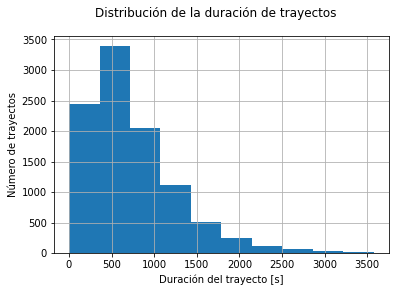

Histograma generado con éxito!


In [ ]:
trips.trip_duration.hist()
plt.xlabel('Duración del trayecto [s]')
plt.ylabel('Número de trayectos')
plt.suptitle('Distribución de la duración de trayectos')
plt.show()
print('Histograma generado con éxito!')

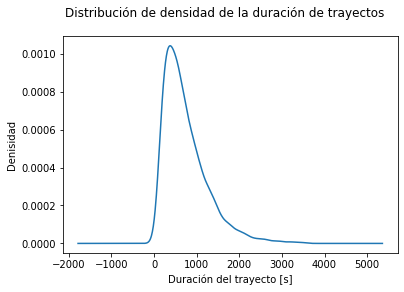

In [ ]:
trips.trip_duration.plot.kde()
plt.xlabel('Duración del trayecto [s]')
plt.ylabel('Denisidad')
plt.suptitle('Distribución de densidad de la duración de trayectos')
plt.show()

In [ ]:
trips.shape[0]  # Muestra la duracion del total de los trayectos mediante distribución en grafica.  

10000

In [ ]:
trips.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
0,514030,2,2016-04-02 00:00:00,2016-04-02 00:17:00,1,2.46,-73.987595,40.754711,-73.959633,40.762836,1,1039,AA,K
1,514031,1,2016-04-02 00:00:00,2016-04-02 00:24:00,2,7.90,-73.924713,40.745567,-73.972763,40.793354,1,1454,L,U
2,514032,1,2016-04-02 00:00:00,2016-04-02 00:19:00,1,1.00,-73.989800,40.732994,-74.000557,40.742622,1,1168,H,Q
3,514033,2,2016-04-02 00:00:00,2016-04-02 00:01:00,1,0.02,-73.987465,40.719822,-73.987289,40.720016,2,35,AC,AC
4,514034,1,2016-04-02 00:01:00,2016-04-02 00:58:00,2,19.00,-73.790131,40.643429,-73.975594,40.779327,1,3470,G,I


In [ ]:
trips.describe()

,id,vendor_id,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,519029.50000,1.527400,1.698100,2.743312,-73.976702,40.749273,-73.974212,40.750304,746.098900
std,2886.89568,0.499274,1.303045,3.134647,0.032755,0.027119,0.031928,0.030314,525.049496
min,514030.00000,1.000000,1.000000,0.000000,-74.027252,40.632393,-74.027252,40.630280,2.000000
25%,516529.75000,1.000000,1.000000,1.000000,-73.992891,40.733330,-73.992287,40.732718,364.000000
50%,519029.50000,2.000000,1.000000,1.700000,-73.983452,40.750420,-73.981422,40.752056,616.000000
75%,521529.25000,2.000000,2.000000,3.200000,-73.968937,40.766482,-73.962952,40.768576,988.000000
max,524029.00000,2.000000,6.000000,32.090000,-73.773987,40.849663,-73.776260,40.849686,3573.000000


<h1>PREGUNTA 1: ANÁLISIS DE DATOS</h1>

**Describa la base de datos ¿Cuántos trayectos hay en la base de datos? ¿Cómo describiría la distribución de la duración de los trayectos? ¿Hay algo que debamos observar?

En la base de datos existen 10000 trayectos. 
Se obseva un sesgo hacia la izquierda de los datos, ya que mayoría de los trayectos son menores a 1000 segundos (aprox un cuarto de hora) y casi todos menores a 2000 segundos (alrededor de media hora). Se trata de tiempos esperables para un recorrido en taxi en una ciudad con Nueva York
La media de la distancia recorrida de los trayectos es de 2.74 y del tiempo de viaje es de 746 segundos.

# Entidades y relaciones

In [ ]:
entities = {
    "trips": (trips, "id", 'pickup_datetime'),
    "pickup_neighborhoods": (pickup_neighborhoods, "neighborhood_id"),
    "dropoff_neighborhoods": (dropoff_neighborhoods, "neighborhood_id"),
}

relationships = [("pickup_neighborhoods", "neighborhood_id", "trips", "pickup_neighborhood"),
                 ("dropoff_neighborhoods", "neighborhood_id", "trips", "dropoff_neighborhood")]

print('Entidades y relaciones definidas con éxito!')

Entidades y relaciones definidas con éxito!


# Primitivas de transformación

In [ ]:
trans_primitives = [Weekend]

# This may take some time to compute
features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude", "trip_duration"]},
                  features_only=True)

print('Primitivas de transformación definidas con éxito!')

Primitivas de transformación definidas con éxito!


Aquí hay algunos atributos que acabamos de crear:

In [ ]:
print(f"Número de atributos: {len(features)}")
features

Número de atributos: 12


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>]

Finalmente, calculamos la matriz de atributos con dichos atributos:

In [ ]:
feature_matrix = compute_features(features, entities, relationships)
preview(feature_matrix, 5)

/usr/local/lib/python3.7/dist-packages/featuretools/computational_backends/calculate_feature_matrix.py:206: UserWarning: Using approximate with a single cutoff_time value or no cutoff_time provides no computational efficiency benefit
  warnings.warn(msg)


Elapsed: 00:00 | Progress: 100%|██████████
Finishing computing...


,vendor_id,pickup_neighborhoods.longitude,dropoff_neighborhood = D,dropoff_neighborhood = AA,dropoff_neighborhood = H,dropoff_neighborhood = P,dropoff_neighborhood = AR,dropoff_neighborhood = AD,dropoff_neighborhood = A,dropoff_neighborhood = AB,...,pickup_neighborhood = B,pickup_neighborhood = AQ,IS_WEEKEND(dropoff_datetime),payment_type,passenger_count,dropoff_neighborhoods.latitude,trip_distance,dropoff_neighborhoods.longitude,IS_WEEKEND(pickup_datetime),pickup_neighborhoods.latitude
id,,,,,,,,,,,,,,,,,,,,,
514030,2,-73.986446,False,False,False,False,False,False,False,False,...,False,False,True,1,1,40.766809,2.46,-73.956886,True,40.757707
514031,1,-73.919159,False,False,False,False,False,False,False,False,...,False,False,True,1,2,40.793597,7.90,-73.969822,True,40.744928
514032,1,-73.991595,False,False,False,False,False,False,False,False,...,False,False,True,1,1,40.740333,1.00,-74.005107,True,40.729652
514033,2,-73.987205,False,False,False,False,False,False,False,False,...,False,False,True,2,1,40.720245,0.02,-73.987205,True,40.720245
514034,1,-73.785073,False,False,False,False,False,False,False,False,...,False,False,True,1,2,40.785005,19.00,-73.976050,True,40.646194


# Primer modelo

In [ ]:
# Separación de los datos de entrenamiento y prueba
X_train, y_train, X_test, y_test = get_train_test_fm(feature_matrix, trips, .75)
y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)

print('Datos separados con éxito!')

Datos separados con éxito!


In [ ]:
# El entrenamiento debería durar alrededor de un minuto
model = GradientBoostingRegressor(verbose=True)
model.fit(X_train, y_train)
print(model.score(X_test, y_test)) # Valor R^2 de la predicción

print('Fase de entrenamiento realizada con éxito!')

      Iter       Train Loss   Remaining Time 
         1           0.4736            4.02s
         2           0.4148            4.08s
         3           0.3661            3.98s
         4           0.3264            3.95s
         5           0.2930            3.95s
         6           0.2660            3.92s
         7           0.2432            3.86s
         8           0.2245            3.86s
         9           0.2090            3.81s
        10           0.1960            3.80s
        20           0.1363            3.39s
        30           0.1199            2.88s
        40           0.1112            2.43s
        50           0.1061            2.01s
        60           0.1028            1.59s
        70           0.1000            1.19s
        80           0.0982            0.79s
        90           0.0959            0.39s
       100           0.0942            0.00s
0.8005981993731162
Fase de entrenamiento realizada con éxito!


<h1 style="color:red;">PREGUNTA 2: PRIMER MODELO</h1>

**Describa todos los atributos que hemos añadido al modelo. ¿Cree que han mejorado el desempeño respecto a un modelo que no contara con ellos? Se han agregado atributos buleanos , ahora tenemos 12 atributos, de los cuales dos nuevos Feature: IS_WEEKEND(dropoff_datetime)>,
 Feature: IS_WEEKEND(pickup_datetime)>, que se desprenden de de drop off y del pickup ¿Por qué? el cumplimiento del trayecto o sea fin de carrera son efectivos y se llevan a cabo.

 Al modelo se ha añadido dos atributos que indican si el viaje se realizó o no durante el fin de semana. Esta información mejora la interpretación de los datos.
 La performance en la fase de entrenamiento aumenta y pasa a ser de un 75% y el tiempo de ejecución es de 4.02 segundos.


[texto del enlace](https://)# Más primitivas de transformación

> Bloque con sangría



In [ ]:
trans_primitives = [Minute, Hour, Day, Week, Month, Weekday, Weekend]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude", "trip_duration"]},
                  features_only=True)

print('Primitivas de tranformación definidas con éxito!')

Primitivas de tranformación definidas con éxito!


In [ ]:
print(f"Número de atributos: {len(features)}")
features

Número de atributos: 24


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: DAY(dropoff_datetime)>,
 <Feature: DAY(pickup_datetime)>,
 <Feature: HOUR(dropoff_datetime)>,
 <Feature: HOUR(pickup_datetime)>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: MINUTE(dropoff_datetime)>,
 <Feature: MINUTE(pickup_datetime)>,
 <Feature: MONTH(dropoff_datetime)>,
 <Feature: MONTH(pickup_datetime)>,
 <Feature: WEEK(dropoff_datetime)>,
 <Feature: WEEK(pickup_datetime)>,
 <Feature: WEEKDAY(dropoff_datetime)>,
 <Feature: WEEKDAY(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>]

In [ ]:
feature_matrix = compute_features(features, entities, relationships)
preview(feature_matrix, 5)

/usr/local/lib/python3.7/dist-packages/featuretools/computational_backends/calculate_feature_matrix.py:206: UserWarning: Using approximate with a single cutoff_time value or no cutoff_time provides no computational efficiency benefit
  warnings.warn(msg)


Elapsed: 00:00 | Progress: 100%|██████████
Finishing computing...


,IS_WEEKEND(dropoff_datetime),WEEK(pickup_datetime),dropoff_neighborhoods.longitude,MINUTE(dropoff_datetime),payment_type,WEEK(dropoff_datetime),DAY(dropoff_datetime),WEEKDAY(dropoff_datetime),WEEKDAY(pickup_datetime),HOUR(dropoff_datetime),...,dropoff_neighborhood = AI,dropoff_neighborhood = AE,dropoff_neighborhood = AQ,vendor_id,dropoff_neighborhoods.latitude,pickup_neighborhoods.longitude,trip_distance,DAY(pickup_datetime),pickup_neighborhoods.latitude,passenger_count
id,,,,,,,,,,,,,,,,,,,,,
514030,True,13,-73.956886,17,1,13,2,5,5,0,...,False,False,False,2,40.766809,-73.986446,2.46,2,40.757707,1
514031,True,13,-73.969822,24,1,13,2,5,5,0,...,False,False,False,1,40.793597,-73.919159,7.90,2,40.744928,2
514032,True,13,-74.005107,19,1,13,2,5,5,0,...,False,False,False,1,40.740333,-73.991595,1.00,2,40.729652,1
514033,True,13,-73.987205,1,2,13,2,5,5,0,...,False,False,False,2,40.720245,-73.987205,0.02,2,40.720245,1
514034,True,13,-73.976050,58,1,13,2,5,5,0,...,False,False,False,1,40.785005,-73.785073,19.00,2,40.646194,2


In [ ]:
# Volver a separar los datos
X_train, y_train, X_test, y_test = get_train_test_fm(feature_matrix, trips, .75)
y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)

print('Datos separados con éxito!')

Datos separados con éxito!


In [ ]:
# El entrenamiento debería durar alrededor de un minuto
model = GradientBoostingRegressor(verbose=True)
model.fit(X_train, y_train)
print(model.score(X_test, y_test)) # Valor R^2 de la predicción

print('Fase de entrenamiento realizada con éxito!')

      Iter       Train Loss   Remaining Time 
         1           0.4736            4.08s
         2           0.4148            3.94s
         3           0.3661            3.86s
         4           0.3264            3.81s
         5           0.2930            3.75s
         6           0.2660            3.75s
         7           0.2432            3.71s
         8           0.2245            3.66s
         9           0.2090            3.64s
        10           0.1960            3.60s
        20           0.1363            3.22s
        30           0.1199            2.79s
        40           0.1112            2.37s
        50           0.1061            1.98s
        60           0.1028            1.57s
        70           0.1000            1.17s
        80           0.0982            0.78s
        90           0.0959            0.39s
       100           0.0942            0.00s
0.7988542791898311
Fase de entrenamiento realizada con éxito!


<h1 style="color:red;">PREGUNTA 3: SEGUNDO MODELO</h1>

**Describa el resto de los atributos nuevos que acabamos de añadir al modelo. ¿Cómo han afectado al desempeño del mismo? ¿Ha tenido que sacrificarse algo de tiempo de entrenamiento? 

Se añadieron 12 atributos nuevos. Esto se ve reflejado en la mejora del desempeño de 75 a 80%, manteniendo el tiempo de desempeño casi invariable (4.08 segundos vs 4.02).
Respecto a los nuevos atributos, algunos parecen ser relevantes (hora, mes) y algunos no parecen tanto (minuto); para otros habría que evaluar con más detenimiento cuánto aportan.
En términos generales, la nueva información resulta útil la hora de predecir nuestra variable.


# Primitivas de agregación

In [ ]:
trans_primitives = [Minute, Hour, Day, Week, Month, Weekday, Weekend]
aggregation_primitives = [Count, Sum, Mean, Median, Std, Max, Min]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=aggregation_primitives,
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude", "trip_duration"]},
                  features_only=True)

print('Primitivas de agregación definidas con éxito!')

Primitivas de agregación definidas con éxito!


In [ ]:
print(f"Número de atributos: {len(features)}")
features

Número de atributos: 62


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: DAY(dropoff_datetime)>,
 <Feature: DAY(pickup_datetime)>,
 <Feature: HOUR(dropoff_datetime)>,
 <Feature: HOUR(pickup_datetime)>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: MINUTE(dropoff_datetime)>,
 <Feature: MINUTE(pickup_datetime)>,
 <Feature: MONTH(dropoff_datetime)>,
 <Feature: MONTH(pickup_datetime)>,
 <Feature: WEEK(dropoff_datetime)>,
 <Feature: WEEK(pickup_datetime)>,
 <Feature: WEEKDAY(dropoff_datetime)>,
 <Feature: WEEKDAY(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>,
 <Feature: pickup_neighborhoods.COUNT(trips)>,
 <Feature: pickup_neighborhoods.MAX(trips.passenger_count)>,
 <Feature: pickup_neighbo

In [ ]:
# Esto podría llevar cierto tiempo de computación, así que sea paciente
feature_matrix = compute_features(features, entities, relationships)
preview(feature_matrix, 5)

/usr/local/lib/python3.7/dist-packages/featuretools/computational_backends/calculate_feature_matrix.py:206: UserWarning: Using approximate with a single cutoff_time value or no cutoff_time provides no computational efficiency benefit
  warnings.warn(msg)


Elapsed: 00:01 | Progress: 100%|██████████
Finishing computing...


,pickup_neighborhoods.MEDIAN(trips.passenger_count),dropoff_neighborhoods.MAX(trips.trip_distance),WEEK(dropoff_datetime),dropoff_neighborhoods.SUM(trips.vendor_id),dropoff_neighborhoods.MEDIAN(trips.passenger_count),pickup_neighborhoods.longitude,dropoff_neighborhoods.MAX(trips.passenger_count),dropoff_neighborhoods.MEAN(trips.trip_distance),dropoff_neighborhoods.MIN(trips.passenger_count),DAY(dropoff_datetime),...,HOUR(pickup_datetime),pickup_neighborhoods.MAX(trips.vendor_id),pickup_neighborhoods.latitude,vendor_id,IS_WEEKEND(dropoff_datetime),dropoff_neighborhoods.MIN(trips.trip_distance),dropoff_neighborhoods.COUNT(trips),WEEK(pickup_datetime),dropoff_neighborhoods.SUM(trips.trip_distance),pickup_neighborhoods.MEDIAN(trips.trip_distance)
id,,,,,,,,,,,,,,,,,,,,,
514030,1.0,21.21,13,464.0,1.0,-73.986446,6.0,2.044915,1.0,2,...,0,2.0,40.757707,2,True,0.00,295.0,13,603.25,1.645
514031,1.0,21.24,13,285.0,1.0,-73.919159,6.0,2.451602,1.0,2,...,0,2.0,40.744928,1,True,0.30,181.0,13,443.74,2.800
514032,1.0,18.80,13,445.0,1.0,-73.991595,6.0,1.899113,1.0,2,...,0,2.0,40.729652,1,True,0.00,293.0,13,556.44,1.590
514033,1.0,18.96,13,426.0,1.0,-73.987205,6.0,2.532340,1.0,2,...,0,2.0,40.720245,2,True,0.00,282.0,13,714.12,2.500
514034,1.0,21.47,13,448.0,1.0,-73.785073,6.0,2.257918,1.0,2,...,0,2.0,40.646194,1,True,0.17,293.0,13,661.57,17.780


In [ ]:
# Volver a separar los datos
X_train, y_train, X_test, y_test = get_train_test_fm(feature_matrix, trips, .75)
y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)

print('Datos separados con éxito!')

Datos separados con éxito!


In [ ]:
# El entrenamiento debería durar alrededor de un minuto
model = GradientBoostingRegressor(verbose=True)
model.fit(X_train, y_train)
print(model.score(X_test, y_test)) # Valor R^2 de la predicción

print('Fase de entrenamiento realizada con éxito!')

      Iter       Train Loss   Remaining Time 
         1           0.4736            5.02s
         2           0.4148            4.62s
         3           0.3661            4.34s
         4           0.3264            4.15s
         5           0.2930            4.08s
         6           0.2660            4.02s
         7           0.2432            4.05s
         8           0.2245            3.98s
         9           0.2090            3.94s
        10           0.1960            3.91s
        20           0.1363            3.40s
        30           0.1199            2.89s
        40           0.1112            2.44s
        50           0.1061            2.00s
        60           0.1028            1.59s
        70           0.1000            1.18s
        80           0.0982            0.80s
        90           0.0959            0.44s
       100           0.0942            0.00s
0.7987407792314217
Fase de entrenamiento realizada con éxito!


# Evaluación con datos de prueba

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.exp(y_pred) - 1 # deshaciendo el log calculado anteriormente
print('Cálculo de y_pred realizado con éxito!')

Cálculo de y_pred realizado con éxito!


In [ ]:
# Mostrando las 5 primeras predicciones
y_pred[:15]

array([ 441.95666471,  674.95900486,  654.59056028,  614.74235757,
        412.77834774, 1447.82258007,  474.85747729, 1161.5875881 ,
        681.63383465,  529.46933614, 1268.16206218,  514.96595097,
        225.48382343,  709.69229227,  390.81364423])

Histograma generado con éxito!!


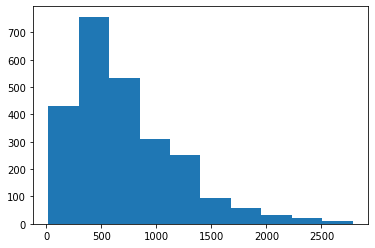

In [ ]:
# Creando un histograma con todas ellas
matplotlib.pyplot.hist(y_pred)

print('Histograma generado con éxito!!')

<h1 style="color:red;">PREGUNTA 4: PREDICCIONES DEL MODELO</h1>

**Analice las predicciones del modelo. ¿Coincide la distribución de los datos predichos con la distribución de los datos reales? ¿Qué otros atributos/estrategias podríamos usar para hacer nuestro modelo aún mejor, si tuvieramos más tiempo?


Lo primero que llama la atención es que aumentó el tiempo de ejecución (5.02 vs 4.08 segundos) respecto al modelo anterior; sin embargo, el desempeño del modelo se mantuvo igual. Esto revela que el agregar variables, no necesariamente mejora el desempeño del modelo ya que no siempre agregan información relevante.
Respecto a la distribución de los datos, se observa que la distribución de los datos es muy similar al de los datos reales (misma forma y sesgo hacia la izquierda). Esto indica que es nuestro modelo está prediciendo de forma correcta.
Para mejorar el modelo se podrían agregar otros atributos, que fueran relevantes al análisis (con cruzamiento de inforamción entre tablas y de otros proveedores de información lateral, tal vez). También se podría ajustar los parámetros del modelo y descartar aquellos que no aportan que se encuentran presentes en este.


# Importancia de los atributos

In [ ]:
feature_importances(model, feature_matrix.columns, n=20)

1: Feature: trip_distance, 0.868
2: Feature: HOUR(pickup_datetime), 0.028
3: Feature: dropoff_neighborhoods.longitude, 0.028
4: Feature: dropoff_neighborhoods.latitude, 0.021
5: Feature: HOUR(dropoff_datetime), 0.013
6: Feature: pickup_neighborhoods.longitude, 0.004
7: Feature: pickup_neighborhoods.SUM(trips.trip_distance), 0.003
8: Feature: pickup_neighborhoods.latitude, 0.003
9: Feature: pickup_neighborhoods.COUNT(trips), 0.003
10: Feature: dropoff_neighborhoods.COUNT(trips), 0.003
11: Feature: dropoff_neighborhoods.SUM(trips.trip_distance), 0.002
12: Feature: pickup_neighborhoods.MEDIAN(trips.trip_distance), 0.002
13: Feature: MINUTE(dropoff_datetime), 0.002
14: Feature: pickup_neighborhoods.MEAN(trips.trip_distance), 0.002
15: Feature: MINUTE(pickup_datetime), 0.001
16: Feature: dropoff_neighborhoods.SUM(trips.vendor_id), 0.001
17: Feature: pickup_neighborhoods.MEAN(trips.passenger_count), 0.001
18: Feature: dropoff_neighborhoods.SUM(trips.passenger_count), 0.001
19: Feature: dropo

<h1 style="color:red;">PREGUNTA 5: IMPORTANCIA DE LOS ATRIBUTOS</h1>

**Analice la importancia de los atributos que acaba de calcular. ¿Tienen sentido? ¿Hay algún valor que le sorprenda?. Aporte una breve explicación de por qué estos atributos son relevante para calcular la variable objetivo `trip_duration` (duración del trayecto).


El atributo de mayor importancia es la distacia recorrida, seguido por la ubicación de destino, la hora y la ubicación de partida. 
Estos resultados parecen coherentes ya que, resulta intuitivo relacionar la distancia recorrida con la duración del viaje. También es de esperar que la hora sea una variable determinante, ya que a horas pico el tráfico es más intenso que a horas no-pico (de madrugada, por ejemplo). Si el lugar de salida/destino es un lugar muy concurrido o congestionado, también puede influir en el tiempo de viaje.
Es lógico que otros atributos, como el método de pago, no resulten relevantes a la hora de estimar la duración del viaje.

In [ ]:
feature_importances(model, feature_matrix.columns, n=20)

1: Feature: trip_distance, 0.868
2: Feature: HOUR(pickup_datetime), 0.028
3: Feature: dropoff_neighborhoods.longitude, 0.028
4: Feature: dropoff_neighborhoods.latitude, 0.021
5: Feature: HOUR(dropoff_datetime), 0.013
6: Feature: pickup_neighborhoods.longitude, 0.004
7: Feature: pickup_neighborhoods.SUM(trips.trip_distance), 0.003
8: Feature: pickup_neighborhoods.latitude, 0.003
9: Feature: pickup_neighborhoods.COUNT(trips), 0.003
10: Feature: dropoff_neighborhoods.COUNT(trips), 0.003
11: Feature: dropoff_neighborhoods.SUM(trips.trip_distance), 0.002
12: Feature: pickup_neighborhoods.MEDIAN(trips.trip_distance), 0.002
13: Feature: MINUTE(dropoff_datetime), 0.002
14: Feature: pickup_neighborhoods.MEAN(trips.trip_distance), 0.002
15: Feature: MINUTE(pickup_datetime), 0.001
16: Feature: dropoff_neighborhoods.SUM(trips.vendor_id), 0.001
17: Feature: pickup_neighborhoods.MEAN(trips.passenger_count), 0.001
18: Feature: dropoff_neighborhoods.SUM(trips.passenger_count), 0.001
19: Feature: dropo

In [ ]:
feature_importances(model, feature_matrix.columns, n=30)

1: Feature: trip_distance, 0.868
2: Feature: HOUR(pickup_datetime), 0.028
3: Feature: dropoff_neighborhoods.longitude, 0.028
4: Feature: dropoff_neighborhoods.latitude, 0.021
5: Feature: HOUR(dropoff_datetime), 0.013
6: Feature: pickup_neighborhoods.SUM(trips.trip_distance), 0.003
7: Feature: pickup_neighborhoods.latitude, 0.003
8: Feature: pickup_neighborhoods.longitude, 0.003
9: Feature: pickup_neighborhoods.COUNT(trips), 0.003
10: Feature: dropoff_neighborhoods.COUNT(trips), 0.003
11: Feature: dropoff_neighborhoods.SUM(trips.trip_distance), 0.002
12: Feature: pickup_neighborhoods.MEDIAN(trips.trip_distance), 0.002
13: Feature: MINUTE(dropoff_datetime), 0.002
14: Feature: pickup_neighborhoods.MEAN(trips.trip_distance), 0.001
15: Feature: dropoff_neighborhoods.SUM(trips.passenger_count), 0.001
16: Feature: MINUTE(pickup_datetime), 0.001
17: Feature: dropoff_neighborhoods.SUM(trips.vendor_id), 0.001
18: Feature: pickup_neighborhood = AU, 0.001
19: Feature: pickup_neighborhoods.MEAN(tri

La variable trip_distance tiene una alta importancia con respecto a la duración del viaje y tiene sentido que entre más sea largo el trayecto más te demores

¡Buen trabajo! Asegúrese de comprobar la sección **Conclusión** del manual de instrucciones del caso de estudio.